##### 加载模块

In [380]:
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tensorboardX import SummaryWriter

from torchLearning import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [381]:
tensorGenCla?

Signature:
tensorGenCla(
    num_samples=500,
    num_features=2,
    num_classes=3,
    deg_dispersion=[4, 2],
    bias=False,
)
Docstring:
生成基础的分类任务数据集的函数

@param num_samples: 数据集中样本的个数
@param num_features: 数据集中每一个样本的特征变量的个数
@param num_classes: 数据集中每一个样本的分类的个数
@param deg_dispersion: 各个类别标签下的数据样本点的均值和标准差的参考数值
@param bias: 逻辑回归模型是否包含截距项

@return: 特征张量和标签
File:      ~/Desktop/prep_PhD/DL/codes/torchLearning.py
Type:      function

In [382]:
torch.tensor?

Docstring:
tensor(data, *, dtype=None, device=None, requires_grad=False, pin_memory=False) -> Tensor

Constructs a tensor with no autograd history (also known as a "leaf tensor", see :doc:`/notes/autograd`) by copying :attr:`data`.

.. warning::

    When working with tensors prefer using :func:`torch.Tensor.clone`,
    :func:`torch.Tensor.detach`, and :func:`torch.Tensor.requires_grad_` for
    readability. Letting `t` be a tensor, ``torch.tensor(t)`` is equivalent to
    ``t.clone().detach()``, and ``torch.tensor(t, requires_grad=True)``
    is equivalent to ``t.clone().detach().requires_grad_(True)``.

.. seealso::

    :func:`torch.as_tensor` preserves autograd history and avoids copies where possible.
    :func:`torch.from_numpy` creates a tensor that shares storage with a NumPy array.

Args:
    data (array_like): Initial data for the tensor. Can be a list, tuple,
        NumPy ``ndarray``, scalar, and other types.

Keyword args:
    dtype (:class:`torch.dtype`, optional): the de

In [383]:
range(-10, 10)  # -10 -9 ... 0 1 2 ... 9

range(-10, 10)

In [384]:
list(range(-10, 10))

[-10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [385]:
def max_x(x, delta=0.):
    x = np.array(x)  # NumPy模块提供的核心数据结构多维数组ndarray可以进行向量化操作
    negative_idx = x < delta  # 向量vector和标量scalar运算的结果是向量vector
    x[negative_idx] = 0.
    return x

In [386]:
x = np.array(range(-10, 10))
s_j = np.array(x)

In [387]:
s_j.ndim

1

In [388]:
s_j.shape

(20,)

Text(0.5, 1.0, 'Max Function')

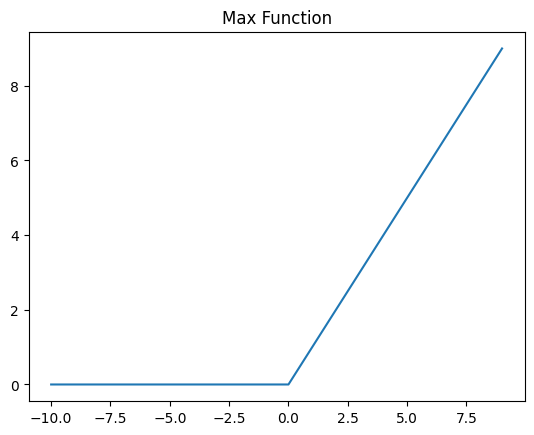

In [389]:
hinge_loss = max_x(x=s_j, delta=1.)
plt.plot(s_j, hinge_loss)
plt.title("Max Function")

In [390]:
def cross_entropy_test(s_k, s_j):
    soft_max = 1. / (1+np.exp(s_k - s_j))
    cross_entropy_loss = -np.log(soft_max)
    return cross_entropy_loss

In [391]:
s_i = 0
s_k = np.array(range(-10, 10))
soft_x = cross_entropy_test(s_k=s_k, s_j=s_i)

Text(0.5, 1.0, 'softmax v.s. max')

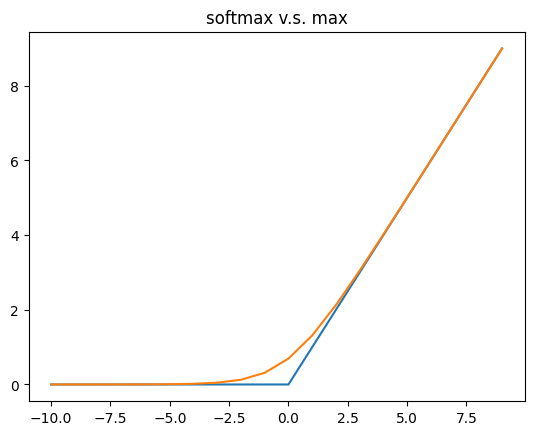

In [392]:
plt.plot(x, hinge_loss)
plt.plot(range(-10, 10), soft_x)
plt.title("softmax v.s. max")
plt.show()

In [393]:
torch.manual_seed(55)

X, y = tensorGenCla(num_classes=3, deg_dispersion=[6, 2], bias=True)

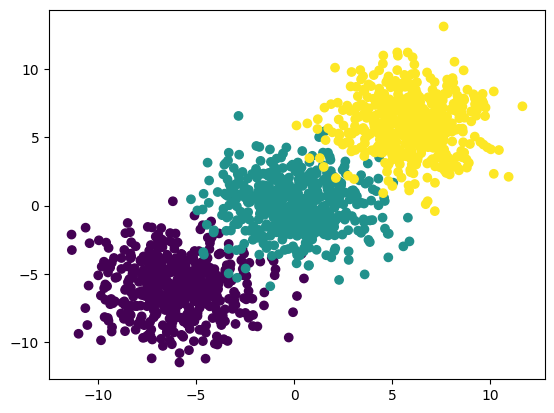

In [394]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [395]:
X

tensor([[-2.2768, -4.1929,  1.0000],
        [-3.3211, -3.5991,  1.0000],
        [-3.9860, -5.5242,  1.0000],
        ...,
        [ 7.2802,  8.1628,  1.0000],
        [ 4.8045,  1.8025,  1.0000],
        [ 6.9511,  5.3047,  1.0000]])

##### 实现softmax函数(基本计算实现)

In [396]:
def softmax(X, w):
    """计算特征张量X和权重向量w整合信息, 然后使用softmax函数加工信息的结果
    @param X: 特征张量
    @param w: 模型的参数
    """
    # 1.整合信息
    z_hat = torch.mm(X, w)
    # 2.加工信息
    # 2-1.计算分子
    numerator = torch.exp(z_hat)
    # 2-2.计算分母
    denominator = torch.sum(torch.exp(z_hat), 1).reshape(-1, 1)
    return numerator / denominator

In [397]:
X_ = X[:10, ]
y_ = y[:10, ] 

In [398]:
X_
y_

tensor([[-2.2768, -4.1929,  1.0000],
        [-3.3211, -3.5991,  1.0000],
        [-3.9860, -5.5242,  1.0000],
        [-6.8394, -4.9284,  1.0000],
        [-6.7662, -1.6466,  1.0000],
        [-4.0709, -5.0306,  1.0000],
        [-9.4861, -8.2251,  1.0000],
        [-6.1148, -9.2789,  1.0000],
        [-7.7441, -6.2952,  1.0000],
        [-6.4714, -4.9117,  1.0000]])

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

In [399]:
w = torch.arange(end=9).reshape(shape=(3, 3)).float()
w

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [400]:
m1 = torch.mm(X_, w)
m1

tensor([[ -6.5788, -12.0485, -17.5182],
        [ -4.7972, -10.7173, -16.6374],
        [-10.5725, -19.0827, -27.5929],
        [ -8.7852, -19.5530, -30.3208],
        [  1.0601,  -6.3528, -13.7656],
        [ -9.0918, -17.1933, -25.2948],
        [-18.6752, -35.3864, -52.0975],
        [-21.8367, -36.2304, -50.6241],
        [-12.8856, -25.9249, -38.9642],
        [ -8.7352, -19.1184, -29.5015]])

In [401]:
torch.sum(input=w, dim=1)

tensor([ 3., 12., 21.])

In [402]:
torch.exp(m1)

tensor([[1.3895e-03, 5.8532e-06, 2.4656e-08],
        [8.2530e-03, 2.2158e-05, 5.9492e-08],
        [2.5610e-05, 5.1581e-09, 1.0389e-12],
        [1.5298e-04, 3.2228e-09, 6.7896e-14],
        [2.8865e+00, 1.7419e-03, 1.0512e-06],
        [1.1259e-04, 3.4123e-08, 1.0342e-11],
        [7.7529e-09, 4.2845e-16, 2.3677e-23],
        [3.2844e-10, 1.8423e-16, 1.0333e-22],
        [2.5343e-06, 5.5077e-12, 1.1970e-17],
        [1.6082e-04, 4.9773e-09, 1.5405e-13]])

In [403]:
torch.sum(input=torch.exp(m1), dim=1)

tensor([1.3954e-03, 8.2752e-03, 2.5616e-05, 1.5298e-04, 2.8883e+00, 1.1262e-04,
        7.7529e-09, 3.2844e-10, 2.5343e-06, 1.6083e-04])

In [404]:
torch.exp(m1) / torch.sum(input=torch.exp(m1), dim=1).reshape(-1, 1)

tensor([[9.9579e-01, 4.1947e-03, 1.7670e-05],
        [9.9732e-01, 2.6777e-03, 7.1892e-06],
        [9.9980e-01, 2.0137e-04, 4.0557e-08],
        [9.9998e-01, 2.1067e-05, 4.4382e-10],
        [9.9940e-01, 6.0311e-04, 3.6396e-07],
        [9.9970e-01, 3.0298e-04, 9.1826e-08],
        [1.0000e+00, 5.5262e-08, 3.0539e-15],
        [1.0000e+00, 5.6090e-07, 3.1461e-13],
        [1.0000e+00, 2.1732e-06, 4.7230e-12],
        [9.9997e-01, 3.0949e-05, 9.5784e-10]])

In [405]:
# 验证每一行的和是否等于1
torch.sum(input=torch.exp(m1) / torch.sum(input=torch.exp(m1), dim=1).reshape(-1, 1),
         dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

In [406]:
# 使用自定义的softmax函数在整合信息后进行加工信息
softmax(X=X_, w=w)

tensor([[9.9579e-01, 4.1947e-03, 1.7670e-05],
        [9.9732e-01, 2.6777e-03, 7.1892e-06],
        [9.9980e-01, 2.0137e-04, 4.0557e-08],
        [9.9998e-01, 2.1067e-05, 4.4382e-10],
        [9.9940e-01, 6.0311e-04, 3.6396e-07],
        [9.9970e-01, 3.0298e-04, 9.1826e-08],
        [1.0000e+00, 5.5262e-08, 3.0539e-15],
        [1.0000e+00, 5.6090e-07, 3.1461e-13],
        [1.0000e+00, 2.1732e-06, 4.7230e-12],
        [9.9997e-01, 3.0949e-05, 9.5784e-10]])

In [407]:
# 使用PyTorch模块提供的softmax函数在整合信息后进行加工信息
F.softmax(input=m1, dim=1)

tensor([[9.9579e-01, 4.1947e-03, 1.7670e-05],
        [9.9732e-01, 2.6777e-03, 7.1892e-06],
        [9.9980e-01, 2.0137e-04, 4.0557e-08],
        [9.9998e-01, 2.1067e-05, 4.4382e-10],
        [9.9940e-01, 6.0311e-04, 3.6396e-07],
        [9.9970e-01, 3.0298e-04, 9.1826e-08],
        [1.0000e+00, 5.5262e-08, 3.0539e-15],
        [1.0000e+00, 5.6090e-07, 3.1461e-13],
        [1.0000e+00, 2.1732e-06, 4.7230e-12],
        [9.9997e-01, 3.0949e-05, 9.5784e-10]])

In [408]:
# 生成特征张量和真实标签
f = torch.tensor([
    [0.6, 0.2, 0.2],
    [0.3, 0.4, 0.3]
], dtype=torch.float32)

l = torch.tensor([0, 1])

In [409]:
f

tensor([[0.6000, 0.2000, 0.2000],
        [0.3000, 0.4000, 0.3000]])

In [410]:
l

tensor([0, 1])

In [2]:
def m_cross_entropy(soft_z, y):
    """在多分类任务中, 计算一个完整的数据集中所有样本的模型预测输出标记和真实标签之间的误差
    @param: soft_z, 一个矩阵, 行是所有样本, 列是模型认为样本属于对应类别的概率
    @param: y, 一个向量, 真实标签
    """
    pass

In [412]:
t = torch.tensor([
        [1, 2],
        [3, 4]
])
t

tensor([[1, 2],
        [3, 4]])

In [413]:
t.ndim

2

In [414]:
t.shape

torch.Size([2, 2])

In [415]:
# dim参数: which axis to index
# index参数: the indices of elements to gather
torch.gather(input=t, dim=1, index=torch.tensor([[0,0], [1,0]]))

tensor([[1, 1],
        [4, 3]])

In [416]:
torch.gather(input=t, dim=0, index=torch.tensor([[0,0], [1,0]]))

tensor([[1, 2],
        [3, 2]])

##### gather()函数相当于对张量进行索引提取元素的函数
##### 通过dim参数(指定维度)和index参数(索引张量), 在指定维度上使用索引张量提取元素

In [417]:
# 假设有一个特征张量, 维度是2, 形状是(2, 3)
x = torch.tensor([
    [10, 11, 12],
    [20, 21, 22]
])

dim = 1  # dim=0 => 第一个维度(行) dim=1 => 第二个维度(列)

# 如果选择了第二个维度, 则第一个维度有第一行和第二行
index = torch.tensor([
    [2, 0],  # 第一行的索引为2和第一行的索引为0
    [1, 1],  # 第二行的索引为1和第二行的索引为1
])

In [418]:
out = torch.gather(input=x, dim=dim, index=index)
out

tensor([[12, 10],
        [21, 21]])

In [419]:
# 假设有一个特征张量, 维度是2, 形状是(2, 3)
x = torch.tensor([
    [10, 11, 12],
    [20, 21, 22],
])

dim = 0  # # dim=0 => 第一个维度(行) dim=1 => 第二个维度(列)

# 如果选择了第一个维度, 则第二个维度有第一列, 第二列和第三列
index = torch.tensor([
    [1, 0, 1],  # 在第一列的索引为1, 第二列的索引为0, 第三列的索引为1 (新生成)
    [0, 0, 1],  # 在第一列的索引为0, 第二列的索引为0, 第三列的索引为1 (新生成)
])

In [420]:
out = torch.gather(input=x, dim=dim, index=index)
out

# 实际输出的结果与预期输出的不符合
# [
#     [11, 10, 11],
#     [20, 20, 21]
# ]

tensor([[20, 11, 22],
        [10, 11, 22]])

In [421]:
l
f

tensor([0, 1])

tensor([[0.6000, 0.2000, 0.2000],
        [0.3000, 0.4000, 0.3000]])

In [422]:
l.reshape(-1, 1).long()

tensor([[0],
        [1]])

In [423]:
index = l.reshape(-1, 1).long()
index
index.ndim
index.shape

tensor([[0],
        [1]])

2

torch.Size([2, 1])

In [424]:
# 在第一行上选择索引为0的列
# 在第二行上选择索引为1的列
torch.gather(input=f, dim=1, index=index)

tensor([[0.6000],
        [0.4000]])

In [425]:
-1. / 2 * torch.log(torch.tensor(0.6) * torch.tensor(0.4))

tensor(0.7136)

In [426]:
-1. / 2 * (torch.log(torch.tensor(0.6)) + torch.log(torch.tensor(0.4)))

tensor(0.7136)

In [427]:
# 假设这个张量存储模型使用softmax函数进行加工信息后, 得到的模型预测各个样本属于各个类别的概率
x = torch.tensor([
    [0.6, 0.2, 0.2],
    [0.3, 0.3, 0.4],
    [0.1, 0.8, 0.1],
])

# 我想从第一行取出0.6, 第二行取出0.4, 第三行取出0.8. 则在行自动迭代的情况下, 我需要指定列索引
dim = 1

# 指定列索引
index = torch.tensor([
    [0],
    [2],
    [1]
])

In [428]:
out = torch.gather(input=x, dim=dim, index=index)
out

tensor([[0.6000],
        [0.4000],
        [0.8000]])

In [429]:
def m_cross_entropy(soft_z, y):
    # 将真实标签y作为索引, 从模型的softmax函数加工信息的输出结果中取出与真实标签对应类别的预测概率
    y = y.long()
    prob_real = torch.gather(input=soft_z, dim=1, index=y)
    return (-1. / y.numel() * torch.log(prob_real).sum())

In [430]:
m_cross_entropy(soft_z=f, y=l.reshape(-1, 1).long())

tensor(0.7136)

In [431]:
f = X[:10, ]
l = y[:10, ]
# 初始化权重矩阵
w = torch.arange(end=9).reshape(3, 3).float()

In [432]:
f

tensor([[-2.2768, -4.1929,  1.0000],
        [-3.3211, -3.5991,  1.0000],
        [-3.9860, -5.5242,  1.0000],
        [-6.8394, -4.9284,  1.0000],
        [-6.7662, -1.6466,  1.0000],
        [-4.0709, -5.0306,  1.0000],
        [-9.4861, -8.2251,  1.0000],
        [-6.1148, -9.2789,  1.0000],
        [-7.7441, -6.2952,  1.0000],
        [-6.4714, -4.9117,  1.0000]])

In [433]:
l

tensor([[0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

In [434]:
w

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [435]:
# 选择损失函数
criterion = nn.CrossEntropyLoss()
# 计算模型预测的输出标记和真实标签之间的误差
loss = criterion(torch.mm(f, w), l.flatten())

In [436]:
loss

tensor(0.0008)

In [437]:
m_cross_entropy(soft_z=softmax(f, w), y=l)

tensor(0.0008)

##### 实现分类准确率数值计算函数

In [438]:
def m_accuracy(soft_z, y):
    """计算分类准确率:
    @param soft_z: 模型预测输出标记, 每一个样本属于各个类别的预测概率
    @param y: 真实标签, 每一个样本的真实标签
    """
    acc_bool = torch.argmax(input=soft_z, dim=1).flatten() == y.flatten()
    accuracy = torch.mean(acc_bool.float())
    return accuracy

In [439]:
soft_z = torch.tensor([
    [0.6, 0.2, 0.2],
    [0.3, 0.3, 0.4],
    [0.1, 0.8, 0.1]
])

max_indices = torch.argmax(input=soft_z, dim=0)
max_indices

tensor([0, 2, 1])

In [440]:
max_indices.flatten() == torch.tensor([0, 2, 1]).flatten()

tensor([True, True, True])

In [441]:
torch.argmax(torch.tensor([1, 2]))

tensor(1)

In [442]:
softmax(f, w)

tensor([[9.9579e-01, 4.1947e-03, 1.7670e-05],
        [9.9732e-01, 2.6777e-03, 7.1892e-06],
        [9.9980e-01, 2.0137e-04, 4.0557e-08],
        [9.9998e-01, 2.1067e-05, 4.4382e-10],
        [9.9940e-01, 6.0311e-04, 3.6396e-07],
        [9.9970e-01, 3.0298e-04, 9.1826e-08],
        [1.0000e+00, 5.5262e-08, 3.0539e-15],
        [1.0000e+00, 5.6090e-07, 3.1461e-13],
        [1.0000e+00, 2.1732e-06, 4.7230e-12],
        [9.9997e-01, 3.0949e-05, 9.5784e-10]])

In [443]:
torch.argmax(input=softmax(f, w), dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [444]:
def sgd(params, lr):
    # 根据梯度信息, 按照一定的方法更新模型中的全部参数
    params.data -= lr * params.grad
    # 清空已经使用过的梯度信息 => 获取当前模型中的参数对应的梯度信息, 然后清空
    params.grad.zero_()

In [445]:
torch.manual_seed(55)

X, y = tensorGenCla(bias=True, deg_dispersion=[6, 2])

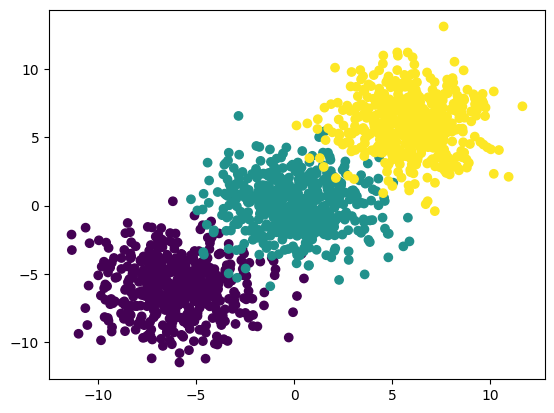

In [446]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [447]:
torch.manual_seed(55)

# 实例化模型
net = softmax
# 初始化模型中的参数
w = torch.randn(size=(3, 3), requires_grad=True, dtype=torch.float32)

# 选择合适的损失函数
criterion = m_cross_entropy
# 选择合适的优化器
eta = 0.03

# 将一个完整的数据集训练多遍
n_epochs = 3
# 将一个完整的数据集按照指定大小拆分成若干个互不相交的子集
batch_size = 10

# 在计算机的内存中逐个存储数值, 选择列表数据结构
accuracies = []

for i_epoch in range(n_epochs):
    for (i_X, i_y) in split_dataset(batch_size=batch_size, X=X, y=y):
        # 1.前向传播
        sigma = net(i_X, w)
        # 2.计算损失
        loss = criterion(sigma, i_y)
        # 3.反向传播
        loss.backward()
        # 4.使用优化器更新模型的参数
        sgd(params=w, lr=eta)

    # 完整学习完一遍完整的数据集后, 以当前模型的参数计算分类准确度
    i_accuracy = m_accuracy(net(X, w), y)
    accuracies.append(i_accuracy)
    print("epoch: %d, accuracy: %f" % (i_epoch+1, i_accuracy))

epoch: 1, accuracy: 0.789333
epoch: 2, accuracy: 0.930667
epoch: 3, accuracy: 0.964667


In [448]:
# 获取模型的参数
w

tensor([[-1.1017, -0.5791, -0.1119],
        [-1.2562, -0.7867, -0.3413],
        [-0.9077,  1.2890, -0.7804]], requires_grad=True)

In [449]:
torch.manual_seed(55)

# 实例化模型
net = softmax
# 初始化模型中的参数
w = torch.randn(size=(3, 3), requires_grad=True, dtype=torch.float32)

# 选择合适的损失函数
criterion = m_cross_entropy
# 选择合适的优化器
eta = 0.03

# 将一个完整的数据集训练多遍
n_epochs = 20
# 将一个完整的数据集按照指定大小拆分成若干个互不相交的子集
batch_size = 10

# 在计算机的内存中逐个存储数值, 选择列表数据结构
accuracies = []

for i_epoch in range(n_epochs):
    for (i_X, i_y) in split_dataset(batch_size=batch_size, X=X, y=y):
        # 1.前向传播
        sigma = net(i_X, w)
        # 2.计算损失
        loss = criterion(sigma, i_y)
        # 3.反向传播
        loss.backward()
        # 4.使用优化器更新模型的参数
        sgd(params=w, lr=eta)

    # 完整学习完一遍完整的数据集后, 以当前模型的参数计算分类准确度
    i_accuracy = m_accuracy(net(X, w), y)
    accuracies.append(i_accuracy)
    print("epoch: %d, accuracy: %f" % (i_epoch+1, i_accuracy))

epoch: 1, accuracy: 0.796000
epoch: 2, accuracy: 0.931333
epoch: 3, accuracy: 0.966667
epoch: 4, accuracy: 0.967333
epoch: 5, accuracy: 0.969333
epoch: 6, accuracy: 0.970667
epoch: 7, accuracy: 0.971333
epoch: 8, accuracy: 0.973333
epoch: 9, accuracy: 0.972667
epoch: 10, accuracy: 0.974000
epoch: 11, accuracy: 0.972667
epoch: 12, accuracy: 0.976000
epoch: 13, accuracy: 0.974000
epoch: 14, accuracy: 0.974667
epoch: 15, accuracy: 0.972667
epoch: 16, accuracy: 0.974667
epoch: 17, accuracy: 0.972667
epoch: 18, accuracy: 0.972667
epoch: 19, accuracy: 0.976667
epoch: 20, accuracy: 0.976000


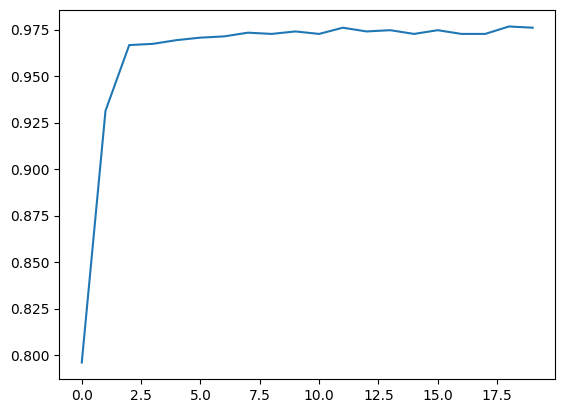

In [450]:
plt.plot(list(range(n_epochs)), accuracies)

In [451]:
accuracies

[tensor(0.7960),
 tensor(0.9313),
 tensor(0.9667),
 tensor(0.9673),
 tensor(0.9693),
 tensor(0.9707),
 tensor(0.9713),
 tensor(0.9733),
 tensor(0.9727),
 tensor(0.9740),
 tensor(0.9727),
 tensor(0.9760),
 tensor(0.9740),
 tensor(0.9747),
 tensor(0.9727),
 tensor(0.9747),
 tensor(0.9727),
 tensor(0.9727),
 tensor(0.9767),
 tensor(0.9760)]

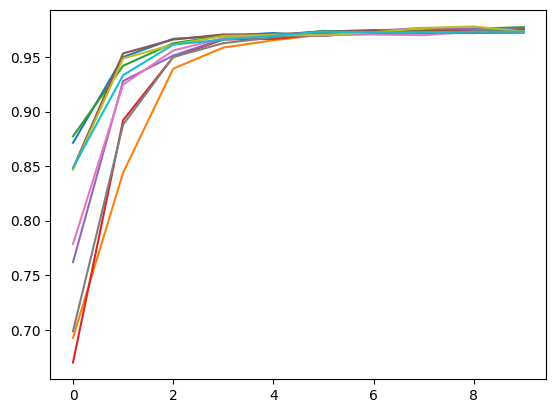

In [452]:
for i in range(10):  # 初始化10组不同的模型的权重
    w = torch.randn(size=(3, 3), requires_grad=True, dtype=torch.float32)
    
    # 在计算机的内存中逐个存储数值, 选择列表数据结构
    accuracies = []
    
    n_epochs = 10
    for i_epoch in range(n_epochs):
        for (i_X, i_y) in split_dataset(batch_size=batch_size, X=X, y=y):
            # 1.前向传播
            sigma = net(i_X, w)
            # 2.计算损失
            loss = criterion(sigma, i_y)
            # 3.反向传播
            loss.backward()
            # 4.使用优化器更新模型的参数
            sgd(params=w, lr=eta)
    
        # 完整学习完一遍完整的数据集后, 以当前模型的参数计算分类准确度
        i_accuracy = m_accuracy(net(X, w), y)
        accuracies.append(i_accuracy)
    plt.plot(list(range(n_epochs)), accuracies)

In [453]:
torch.manual_seed(55)

# 加载数据
X, y = tensorGenCla(deg_dispersion=[6, 1])
y = y.float()

In [454]:
X

tensor([[-4.1384, -5.0965],
        [-4.6605, -4.7995],
        [-4.9930, -5.7621],
        ...,
        [ 6.6401,  7.0814],
        [ 5.4022,  3.9013],
        [ 6.4755,  5.6523]])

In [455]:
y

tensor([[0.],
        [0.],
        [0.],
        ...,
        [2.],
        [2.],
        [2.]])

In [456]:
# 搭建模型: 使用面向对象(定义类/创建对象)的方式 继承nn.Module类
class GeoffNet(nn.Module):
    # 构造器 + 类/对象属性
    # => 子类的对象调用父类的构造器
    # => 神经网络模型中的各种层
    def __init__(self, in_features=2, out_features=3, bias=True):
        super(GeoffNet, self).__init__()

        # 输出层
        self.output_linear = nn.Linear(in_features=in_features, out_features=out_features, bias=bias)

    # 方法
    # => 前向传播: 数据从神经网络的输入层 -> 隐藏层 -> 输出层; 逐层完成整合信息+加工信息
    def forward(self, X):
        # 输入层 -> 输出层
        # 1.加工信息
        z_hat = self.output_linear(X)
        # 2.加工信息
        # sigma = F.softmax(z_hat, dim=1)
        # return sigma

        return z_hat

# 实例化模型
net = GeoffNet()

In [457]:
# 选择合适的损失函数
criterion = nn.CrossEntropyLoss()

In [458]:
# 选择合适的优化器
eta = 0.03
opitimizer = optim.SGD(params=net.parameters(), lr=eta)

In [459]:
# 搭建深度神经网络模型的训练流程
# 数据
# =====> 将特征张量和真实标签按照样本索引打包, 组成完整的数据集
dataset = TensorDataset(X, y)
# =====> 将一个完整的数据集训练多遍
n_epochs = 3
# =====> 将一个完整的数据集按照指定大小拆分成若干个互不相交的子集
batch_size = 10
batched_dataset = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=False)

In [460]:
def prepare_dataset(X, y, batch_size):
    """
    先将特征张量和真实标签按照样本索引打包, 组成完整的数据集
    再将一个完整的数据集按照指定大小拆分成若干个互不相交的子集
    @param X: 特征张量
    @param y: 标签
    @param batch_size: 子集的大小
    """
    dataset = TensorDataset(X, y)
    batched_dataset = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    return batched_dataset

In [461]:
def fit(batched_dataset, n_epochs, model, criterion, opitimizer):
    for i_epoch in range(n_epochs):
        for (i_X, i_y) in batched_dataset:
            # 1.前向传播
            z_hat = model.forward(i_X)
            # 2.计算损失
            i_y = i_y.flatten().long()
            loss = criterion(z_hat, i_y)
            # print(loss)
            # 3.反向传播
            loss.backward()
            # 4.使用优化器更新模型的参数
            optimizer.step()
            optimizer.zero_grad()

In [462]:
batched_dataset = prepare_dataset(X=X, y=y, batch_size=batch_size)
fit(batched_dataset=batched_dataset, n_epochs=n_epochs,
   model=net,
   criterion=criterion,
   opitimizer=opitimizer)

In [463]:
net

GeoffNet(
  (output_linear): Linear(in_features=2, out_features=3, bias=True)
)

In [464]:
list(net.parameters())

[Parameter containing:
 tensor([[-0.2196,  0.1759],
         [-0.0526, -0.4517],
         [-0.6836,  0.5815]], requires_grad=True),
 Parameter containing:
 tensor([-0.5230,  0.5798,  0.6826], requires_grad=True)]

In [465]:
loss = criterion(net.forward(X), y.flatten().long())
loss

tensor(1.8468, grad_fn=<NllLossBackward0>)

In [466]:
m_accuracy(F.softmax(net.forward(X), dim=1), y)

tensor(0.4607)

In [467]:
F.softmax(net.forward(X), dim=1)

tensor([[0.0245, 0.9050, 0.0705],
        [0.0301, 0.8454, 0.1245],
        [0.0189, 0.9193, 0.0618],
        ...,
        [0.2620, 0.0281, 0.7099],
        [0.3370, 0.2164, 0.4466],
        [0.3455, 0.0884, 0.5661]], grad_fn=<SoftmaxBackward0>)

In [468]:
torch.manual_seed(420)

# 加载数据集
X, y = tensorGenCla(deg_dispersion=[6, 2])
y = y.float()

batch_size = 10
batched_dataset = prepare_dataset(X=X, y=y, batch_size=batch_size)

In [469]:
torch.manual_seed(420)

n_epochs = 20
SF1 = GeoffNet()
cr1 = nn.CrossEntropyLoss()
op1 = optim.SGD(params=SF1.parameters(), lr=eta)

# 在计算机的内存中逐个存储数值, 选择列表数据结构
accuracies = []

for epochs in range(n_epochs):
    fit(batched_dataset=batched_dataset, n_epochs=n_epochs,
        model=SF1,
        criterion=cr1,
        opitimizer=op1)
    epoch_accuracy = m_accuracy(F.softmax(SF1(X), dim=1), y)
    accuracies.append(epoch_accuracy)

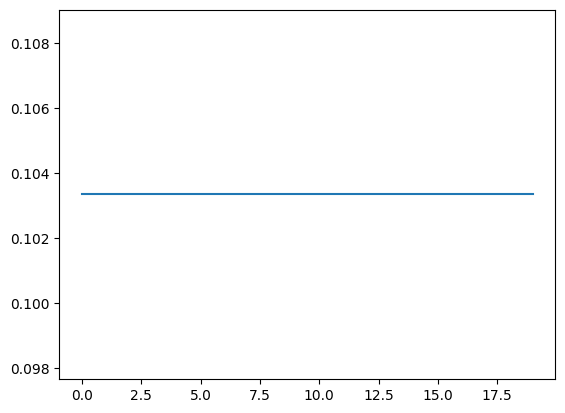

In [470]:
plt.plot(list(range(n_epochs)), accuracies)

In [471]:
torch.manual_seed(55)

X, y = tensorGenCla(deg_dispersion=[6, 4])
y = y.float()

batched_dataset = prepare_dataset(X=X, y=y, batch_size=10)

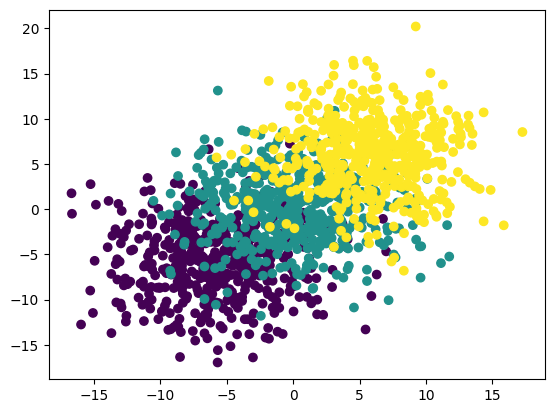

In [472]:
plt.scatter(X[:, 0], X[:, 1], c=y)

In [473]:
torch.manual_seed(55)

n_epochs = 20
SF1 = GeoffNet()
cr1 = nn.CrossEntropyLoss()
op1 = optim.SGD(params=SF1.parameters(), lr=eta)

# 在计算机的内存中逐个存储数值, 选择列表数据结构
accuracies = []

for epochs in range(n_epochs):
    fit(batched_dataset=batched_dataset, n_epochs=n_epochs,
        model=SF1,
        criterion=cr1,
        opitimizer=op1)
    epoch_accuracy = m_accuracy(F.softmax(SF1(X), dim=1), y)
    accuracies.append(epoch_accuracy)

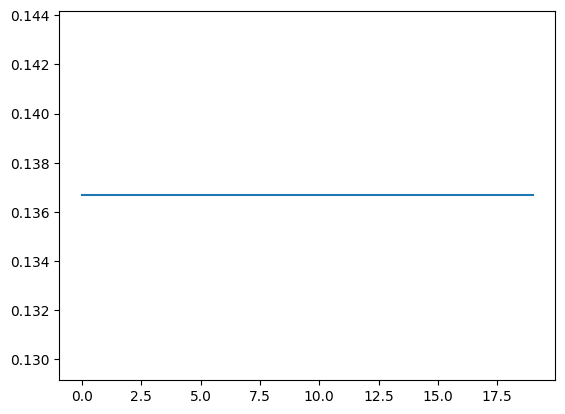

In [474]:
plt.plot(list(range(n_epochs)), accuracies)

In [475]:
cr1 = nn.CrossEntropyLoss()

train_acc = []

for i in range(10):
    SF1 = GeoffNet()
    op1 = optim.SGD(SF1.parameters(), lr=eta)
    fit(batched_dataset=batched_dataset, n_epochs=10,
       model=SF1, criterion=cr1, opitimizer=op1)

    epoch_acc = m_accuracy(F.softmax(SF1(X), dim=1), y)
    train_acc.append(epoch_acc)

In [477]:
train_acc

[tensor(0.5127),
 tensor(0.2627),
 tensor(0.3847),
 tensor(0.1607),
 tensor(0.5040),
 tensor(0.4993),
 tensor(0.0673),
 tensor(0.0633),
 tensor(0.0713),
 tensor(0.2747)]

In [478]:
# 加载数据
n_dots = 20
x = np.linspace(0, 1, n_dots)
# 相关关系 = 因果关系 + noise
y = np.sqrt(x) - 0.1 + 0.2 * np.random.rand(n_dots) 

In [481]:
def plot_polynomial_fit(x, y, deg):
    p = np.poly1d(np.polyfit(x, y, deg))
    t = np.linspace(0, 1, 200)
    plt.plot(x, y, 'ro', t, p(t), '-')

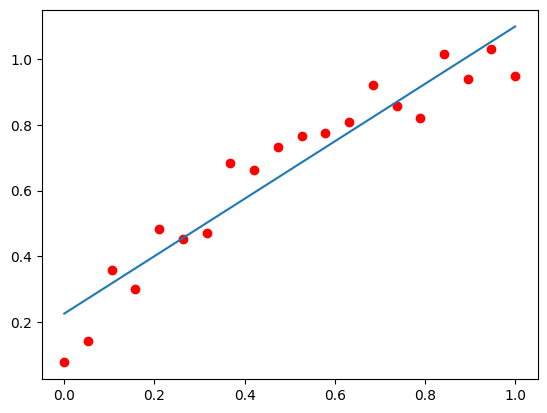

In [482]:
plot_polynomial_fit(x=x, y=y, deg=1)

In [483]:
# 判断当前安装的pytorch模块是否支持GPU计算
torch.cuda.is_available()

False

In [485]:
tc = torch.randn(size=(4, ))
tc

tensor([-1.5850,  1.0447,  1.6468, -0.3469])

In [486]:
tg = tc.cuda()
tg

AssertionError: Torch not compiled with CUDA enabled

In [487]:
tc = tc.cpu()
tc

tensor([-1.5850,  1.0447,  1.6468, -0.3469])

In [488]:
tc.to("cpu")

tensor([-1.5850,  1.0447,  1.6468, -0.3469])

In [489]:
tc.to("cuda")

AssertionError: Torch not compiled with CUDA enabled

In [490]:
tc.device

device(type='cpu')

In [491]:
torch.randn(size=(4, ), device=tc.device)

tensor([ 1.1191, -0.5461, -1.5101, -0.7417])

In [492]:
# 加载数据
X, y = tensorGenCla()

# 如果当前pytorch是GPU版本
cuda_state = torch.cuda.is_available()

if cuda_state == True:  # 如果当前pytorch是GPU版本
    X = X.cuda()
    y = y.cuda()
    net = GeoffNet().cuda()
else:
    net = GeoffNet()